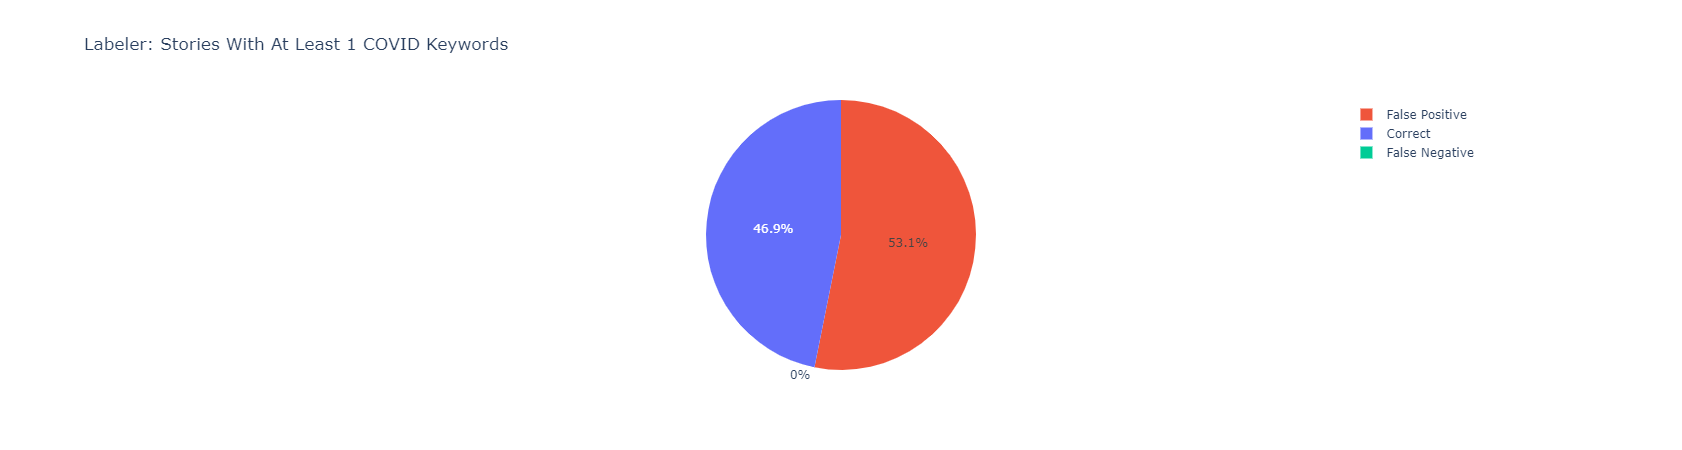

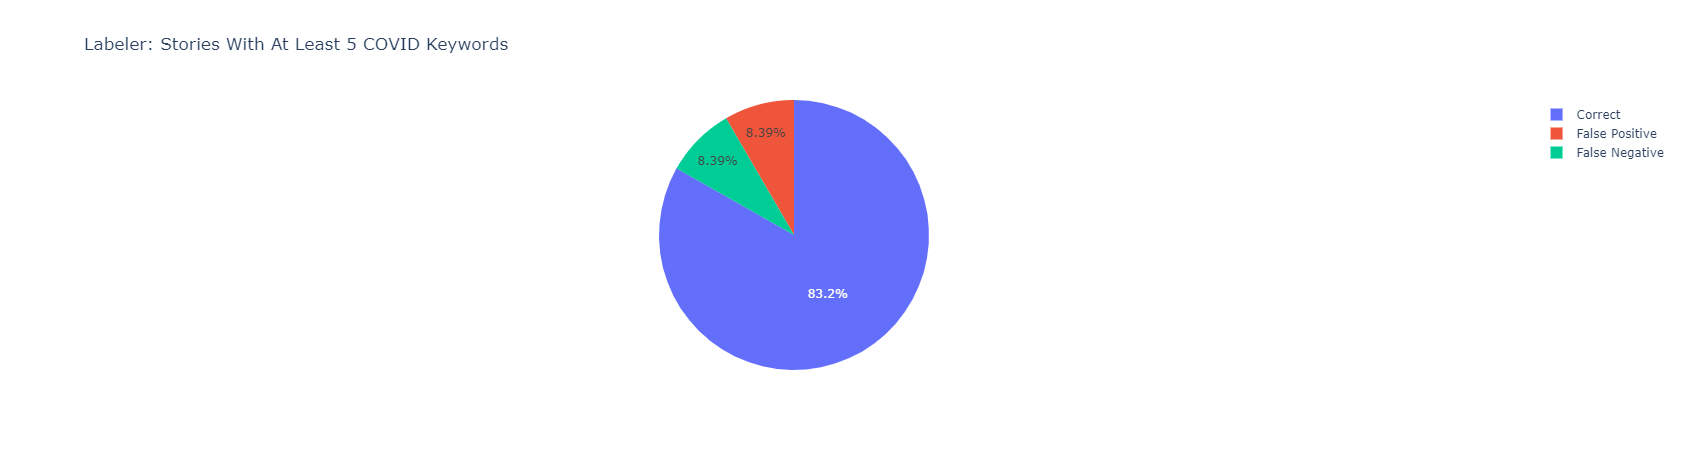

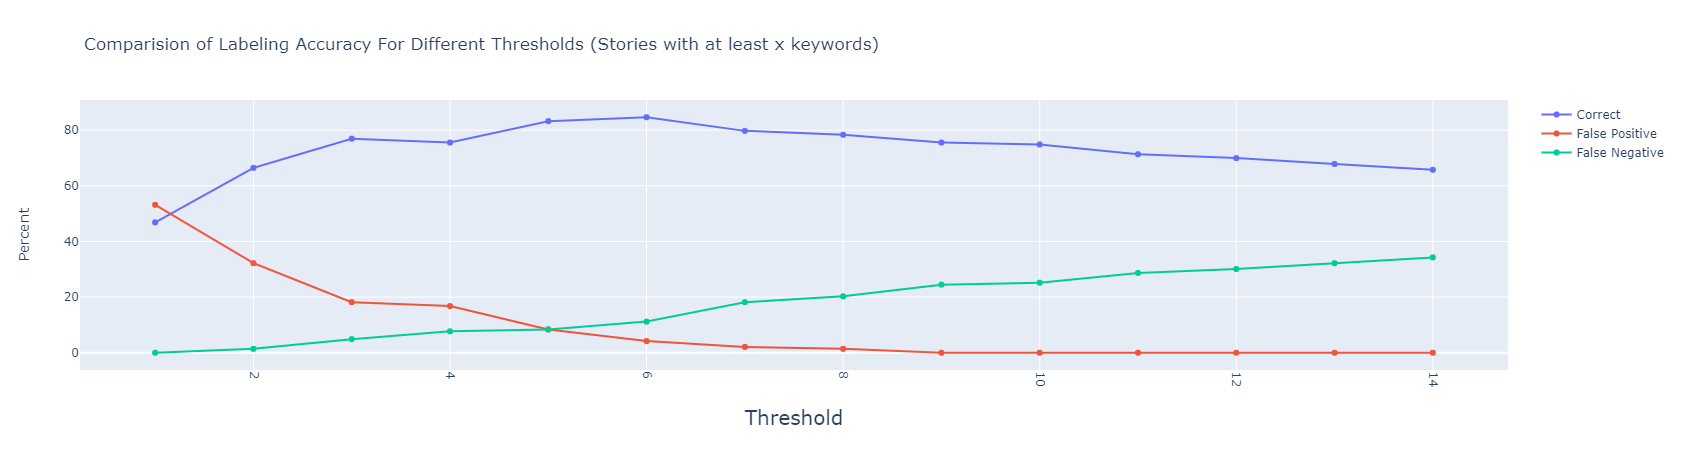

In [322]:
from typing import List

import json
import os
#import application.data_labeler as labeler
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
#import re

COVID_KEYWORDS = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant',
]

KEYS_TO_BALANCE = ('GDELT', 'Actor1Geo_CountryCode')

KEYS_TO_KEEP = [
    ('GDELT', 'SOURCEURL'),
    ('LABEL', 'WANT_ON_MAP'),
    ('ARTICLE', 'TEXT'),
    ('ARTICLE', 'TITLE'),
]
PLOTLY_COLORS = ['#636EFA', '#EF553B','#00CC96'] #included so that all the pie charts match the same colors to their labels


    
def isNaN(num):
    return num != num

def containsNaN(data):
    return isNaN(data['LABEL.WANT_ON_MAP']) or isNaN(data['ARTICLE.TITLE']) or isNaN(data['ARTICLE.TEXT'])

def _covid_in_string(string: str):
    return any(w in string.lower() for w in COVID_KEYWORDS)

def _covid_in_data(data: dict):
    return _covid_in_string(data['ARTICLE.TITLE']) or \
        _covid_in_string(data['ARTICLE.TEXT'])

def _file_contents_to_dataframe(data_dicts: List[dict],
                                columns_to_keep: List[str]) -> pd.DataFrame:
    dataframe = pd.json_normalize(data_dicts)
    dataframe = dataframe[columns_to_keep]
    return dataframe

def load_files_from_directory(directory: str) -> List[str]:
    file_contents = []
    for file_path in os.listdir(directory):
        full_file_path = os.path.join(directory, file_path)
        if os.path.isdir(full_file_path):
            continue
        with open(full_file_path, 'r') as file:
            file_content = json.load(file)
        file_contents.append(file_content)
    return file_contents

def df_manually_labelled_only(df):
    drop_indeces = []
    for index, row in df.iterrows():
        if containsNaN(row) or not _covid_in_data(row):
            drop_indeces.append(index)
    df = df.drop(df.index[drop_indeces]) 
    return df
def df_with_frequency(df):
    df['KEYWORD_FREQUENCY'] = 0
    for index, row in df.iterrows():
            df.loc[index,'KEYWORD_FREQUENCY'] = get_total_keywords(row)
    return df
def get_keyword_total_for(line):
    total = 0
    line = line.strip() 
    line = line.lower() 
    words = line.split(" ") 
    for word in words: 
        if any(w in word for w in COVID_KEYWORDS): 
            total = total + 1
    return total
def get_total_keywords(row):
    total = get_keyword_total_for(row['ARTICLE.TITLE']) + get_keyword_total_for(row['ARTICLE.TEXT'])
    return total
def get_prediction_stats_for_threshold(df, threshold):
    false_positives = 0
    false_negatives = 0
    total_stories = 0
    for index, row in df.iterrows():
        total_stories = total_stories + 1
        want_on_map = row['KEYWORD_FREQUENCY'] >= threshold
        if not (want_on_map == row['LABEL.WANT_ON_MAP']):
            if want_on_map:
                false_positives = false_positives + 1;
            else:
                false_negatives = false_negatives + 1;
    obj = {
        "correct": total_stories-false_positives-false_negatives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
    }
    return obj
def plot_predict(df, keyword_threshold):
    stats = get_prediction_stats_for_threshold(df, keyword_threshold)
    labels = ['Correct', 'False Positive', 'False Negative']
    values = [stats['correct'], stats['false_positives'], stats['false_negatives']]
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(title_text='Labeler: Stories With At Least '+ str(keyword_threshold) + ' COVID Keywords')
    fig.update_traces(marker=dict(colors=PLOTLY_COLORS))
    fig.show()  
def plot_change(df, min_range, max_range):
    correct = []
    false_positives = []
    false_negatives = []
    total_stories = df.shape[0]
    for i in range(min_range,max_range):
        stats = get_prediction_stats_for_threshold(df, i)
        correct.append(stats['correct']/total_stories*100)
        false_positives.append(stats['false_positives']/total_stories*100)
        false_negatives.append(stats['false_negatives']/total_stories*100)
    x = list(range(min_range,max_range))
    fig = go.Figure(data=[
                        go.Scatter(x=x, y=correct, name= "Correct"),
                        go.Scatter(x=x, y=false_positives, name= "False Positive"),
                        go.Scatter(x=x, y=false_negatives, name= "False Negative"),
                         ])
    fig.update_xaxes(
        tickangle = 90,
        title_text = "Threshold",
        title_font = {"size": 20},
        title_standoff = 25)
    fig.update_yaxes(
        title_text = "Percent",
        title_standoff = 25)
    fig.update_layout(title_text='Comparision of Labeling Accuracy For Different Thresholds (Stories with at least x keywords)')
    fig.show()
def main():
    x = load_files_from_directory("../data/news_articles/balanced_dataset/")
    columns_to_keep = ['.'.join(keys) for keys in KEYS_TO_KEEP]
    df = df_manually_labelled_only(_file_contents_to_dataframe(x, columns_to_keep));
    df = df_with_frequency(df)
    plot_predict(df, 1)
    plot_predict(df, 5)
    plot_change(df, 1, 15)
main(); 

1